# STEP2: Train model - Data 2020

In [1]:
cd ..

/home/ducbui/Documents/code_choi/MP


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
df = pd.read_csv('final_data.csv')
df = df[df['YEAR'] == 2020]


In [5]:
df.head()

,CODE,NAME,STOCK EXCHANGE,YEAR,TARGET,EBIT,EBITDA,TOTAL EQUITY/TOTAL ASSETS,EPS,CASH/TOTAL CURRENT ASSETS,...,LONG-TERM ASSETS/TOTAL ASSETS,QUICK RATIO,Market Value of Total Equity / Book Values of Total Liabilities,Sales/Total Assets,EBIT/Total Assets,Retain Earnings/Total Assets,Working Capitals/Total Asset,ROIC,AGE,NET INCOME/TOTAL ASSET
574,AAA,CTCP Nhựa An Phát Xanh,1,2020,1.0,0.020505,0.054108,-0.069427,-0.099934,-0.466701,...,-0.290667,-0.276570,-0.255907,-0.095541,-0.070363,-0.085431,-0.130749,-0.203444,18.0,-0.287191
575,AAM,CTCP Thủy sản MeKong,1,2020,0.0,-0.196471,-0.216320,-0.069260,-0.107093,-0.466706,...,-0.295145,0.256347,0.288791,-0.116823,-0.125471,-0.105190,0.142585,-1.201838,18.0,-1.468328
576,AAV,CTCP AAV Group,0,2020,0.0,-0.182761,-0.203443,-0.069362,-0.104781,-0.466719,...,-0.291358,-0.217129,-0.122770,-0.120019,-0.081849,-0.084651,-0.037397,-0.441399,10.0,-0.400631
577,ABR,CTCP Đầu tư Nhãn hiệu Việt,1,2020,0.0,-0.179422,-0.200409,-0.069288,-0.090668,-0.466677,...,-0.293469,0.514607,0.623227,-0.134214,-0.048550,-0.068299,0.064619,0.214882,8.0,0.482733
578,ABS,CTCP Dịch vụ Nông nghiệp Bình Thuận,1,2020,1.0,-0.164113,-0.189915,-0.069443,-0.102270,-0.466719,...,-0.293999,-0.190483,-0.226776,-0.089926,-0.071736,-0.095422,-0.119607,-0.001902,16.0,-0.147361


## Chia tập Train và Test

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['TARGET', 'CODE', 'NAME', 'YEAR', 'STOCK EXCHANGE'], axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(492, 16) (492,)
(123, 16) (123,)


In [7]:
# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("classifier", RandomForestClassifier())
    ]
)

# training
completed_pl.fit(X_train, y_train)

# accuracy
y_train_pred = completed_pl.predict(X_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}")

y_pred = completed_pl.predict(X_test)
print(f"Accuracy on test: {accuracy_score(list(y_test), list(y_pred)):.2f}")

Accuracy on train: 1.00
Accuracy on test: 0.93


In [8]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import numpy as np

# Tính fbeta score
def fbeta(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=np.sqrt(2))

metric = make_scorer(fbeta)

In [9]:
models = {
  'LogisticRegression': LogisticRegression(),
  'GaussianNB': GaussianNB(),
  'KNeighborsClassifier': KNeighborsClassifier(),
  # 'SVM': SVC(),
  'MLPClassifier': MLPClassifier(),
  'DecisionTree': DecisionTreeClassifier(),
  'RandomForestClassifier': RandomForestClassifier(),
  'GDBoosting': GradientBoostingClassifier()
}

# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

all_scores = []
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for key,model in models.items():
  completed_pl = Pipeline(
    steps=[('classifier', model)]
  )
  scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
  models[key] = completed_pl.fit(X_train, y_train)
  y_pred = completed_pl.predict(X_test)
  y_scores = model.predict_proba(X_test)[:, 1] 
  report = classification_report(y_test, y_pred)
  # Tính AUROC
  auroc = roc_auc_score(y_test, y_scores)

  # Tính AUC-PR
  precision, recall, _ = precision_recall_curve(y_test, y_scores)
  auc_pr = auc(recall, precision)
  all_scores.append(scores)
  print(f"==========Model: {model}==========")
  print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
  print(report)
  print(f"AUROC: {auroc}")
  print(f"AUC-PR: {auc_pr}")

/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

==========Model: LogisticRegression()==========
Mean Fbeta: 0.875 0.051
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85        64
         1.0       0.81      0.88      0.85        59

    accuracy                           0.85       123
   macro avg       0.85      0.85      0.85       123
weighted avg       0.85      0.85      0.85       123

AUROC: 0.9361758474576272
AUC-PR: 0.8864134789738244
==========Model: GaussianNB()==========
Mean Fbeta: 0.857 0.039
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.85        64
         1.0       0.78      1.00      0.87        59

    accuracy                           0.86       123
   macro avg       0.89      0.87      0.86       123
weighted avg       0.89      0.86      0.86       123

AUROC: 0.9679555084745763
AUC-PR: 0.9131821388649912
==========Model: KNeighborsClassifier()==========
Mean Fbeta: 0.700 0.074
              precision    rec

/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

==========Model: MLPClassifier()==========
Mean Fbeta: 0.857 0.053
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87        64
         1.0       0.83      0.92      0.87        59

    accuracy                           0.87       123
   macro avg       0.87      0.87      0.87       123
weighted avg       0.87      0.87      0.87       123

AUROC: 0.9414724576271186
AUC-PR: 0.9058668735871361
==========Model: DecisionTreeClassifier()==========
Mean Fbeta: 0.948 0.032
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94        64
         1.0       0.92      0.97      0.94        59

    accuracy                           0.94       123
   macro avg       0.94      0.94      0.94       123
weighted avg       0.94      0.94      0.94       123

AUROC: 0.9439883474576272
AUC-PR: 0.9508583481132789
==========Model: RandomForestClassifier()==========
Mean Fbeta: 0.940 0.032
              precisi

Text(0.5, 1.0, 'Scores Metrics')

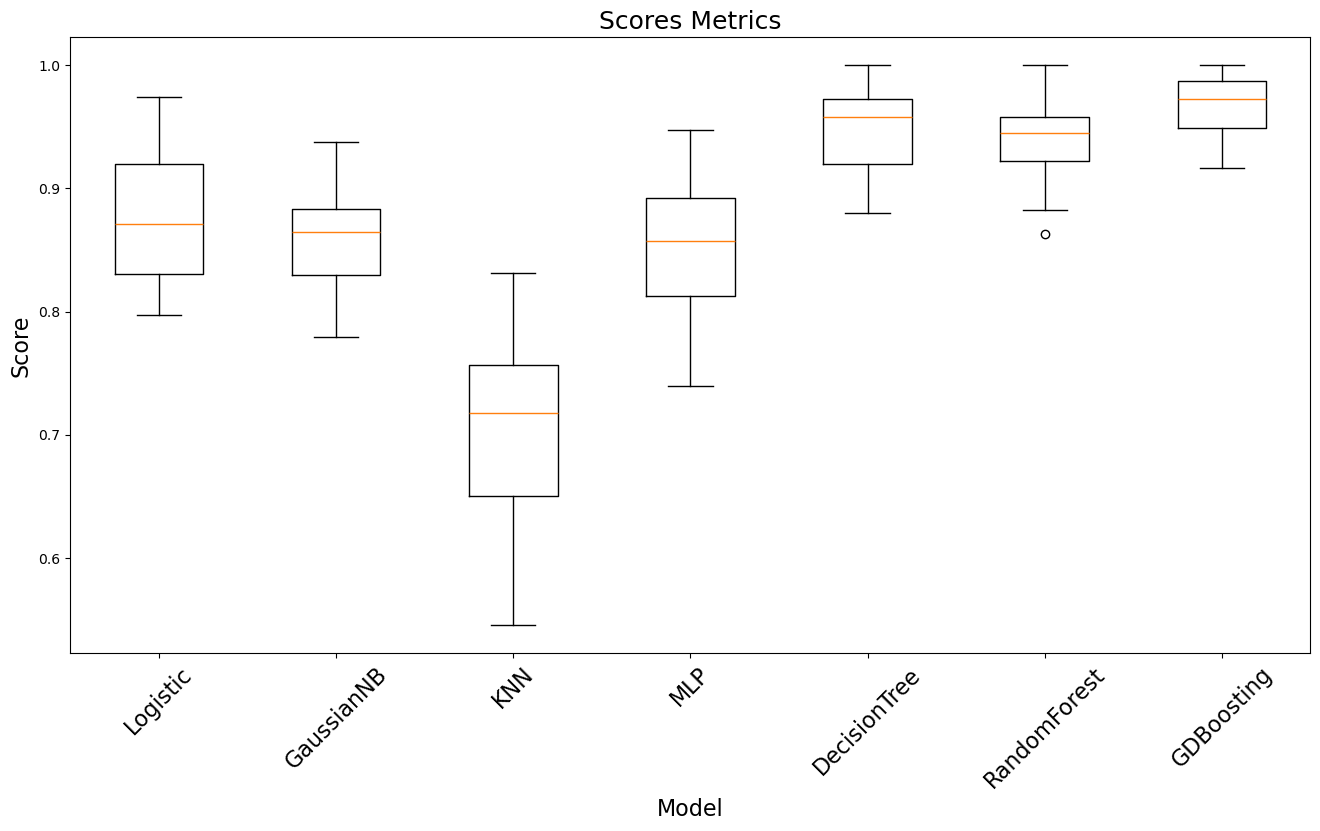

In [10]:
import matplotlib.pyplot as plt
model_names = ['Logistic', 'GaussianNB', 'KNN', 'MLP','DecisionTree', 'RandomForest', 'GDBoosting']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

Nhìn vào biểu đồ ta có thể thấy GradientBoosting là thuật toán có độ chính xác cao nhất khi score trung bình đạt được khoảng 0.9, độ ổn định cao nên chúng ta sẽ lựa chọn lớp mô hình này để phát triển thành production.

## Grid Search

In [11]:
from sklearn.base import BaseEstimator
class ClassifierSwitcher(BaseEstimator):
  def __init__(
      self, 
      estimator = GradientBoostingClassifier(),
  ):
      """
      A Custom BaseEstimator that can switch between classifiers.
      :param estimator: sklearn object - The classifier
      """ 
      
      self.estimator = estimator


  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self


  def predict(self, X, y=None):
      return self.estimator.predict(X)


  def predict_proba(self, X):
      return self.estimator.predict_proba(X)


  def score(self, X, y):
      return self.estimator.score(X, y)

In [12]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    steps=[("clf", ClassifierSwitcher())]
)

In [13]:
parameters = [
    {
        'clf__estimator': [GradientBoostingClassifier()],
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth': [5, 10],
        'clf__estimator__criterion': ('gini', 'entropy', "friedman_mse",  "mae")
    },
]

In [14]:
metric = make_scorer(fbeta)
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, scoring=metric, return_train_score=True, error_score=0, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf_

[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.0

/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
  

GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('clf', ClassifierSwitcher())]),
             n_jobs=12,
             param_grid=[{'clf__estimator': [GradientBoostingClassifier()],
                          'clf__estimator__criterion': ('gini', 'entropy',
                                                        'friedman_mse', 'mae'),
                          'clf__estimator__max_depth': [5, 10],
                          'clf__estimator__n_estimators': [50, 100]}],
             return_train_score=True,
             scoring=make_scorer(fbeta, response_method='predict'), verbose=3)

In [15]:
gscv.best_score_

0.9562051031527433

In [16]:
best_model = gscv.best_estimator_

In [17]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95        64
         1.0       0.93      0.97      0.95        59

    accuracy                           0.95       123
   macro avg       0.95      0.95      0.95       123
weighted avg       0.95      0.95      0.95       123



In [18]:

# joblib.dump(best_model, 'best_model_grid_search.pkl')


## XGBoost training

In [19]:
from xgboost import XGBClassifier
# Initialize XGBoost classifier
xgboost_model = XGBClassifier()

# Perform cross-validation
scores = cross_val_score(xgboost_model, X, y, cv=5, scoring=metric)
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
y_scores = xgboost_model.predict_proba(X_test)[:, 1] 
report = classification_report(y_test, y_pred)
# Tính AUROC
auroc = roc_auc_score(y_test, y_scores)

# Tính AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
all_scores.append(scores)
print(f"==========Model: XGBoost==========")
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
print(report)
print(f"AUROC: {auroc}")
print(f"AUC-PR: {auc_pr}")

==========Model: XGBoost==========
Mean Fbeta: 0.966 0.012
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        64
         1.0       0.95      0.98      0.97        59

    accuracy                           0.97       123
   macro avg       0.97      0.97      0.97       123
weighted avg       0.97      0.97      0.97       123

AUROC: 0.996292372881356
AUC-PR: 0.9959527184641802


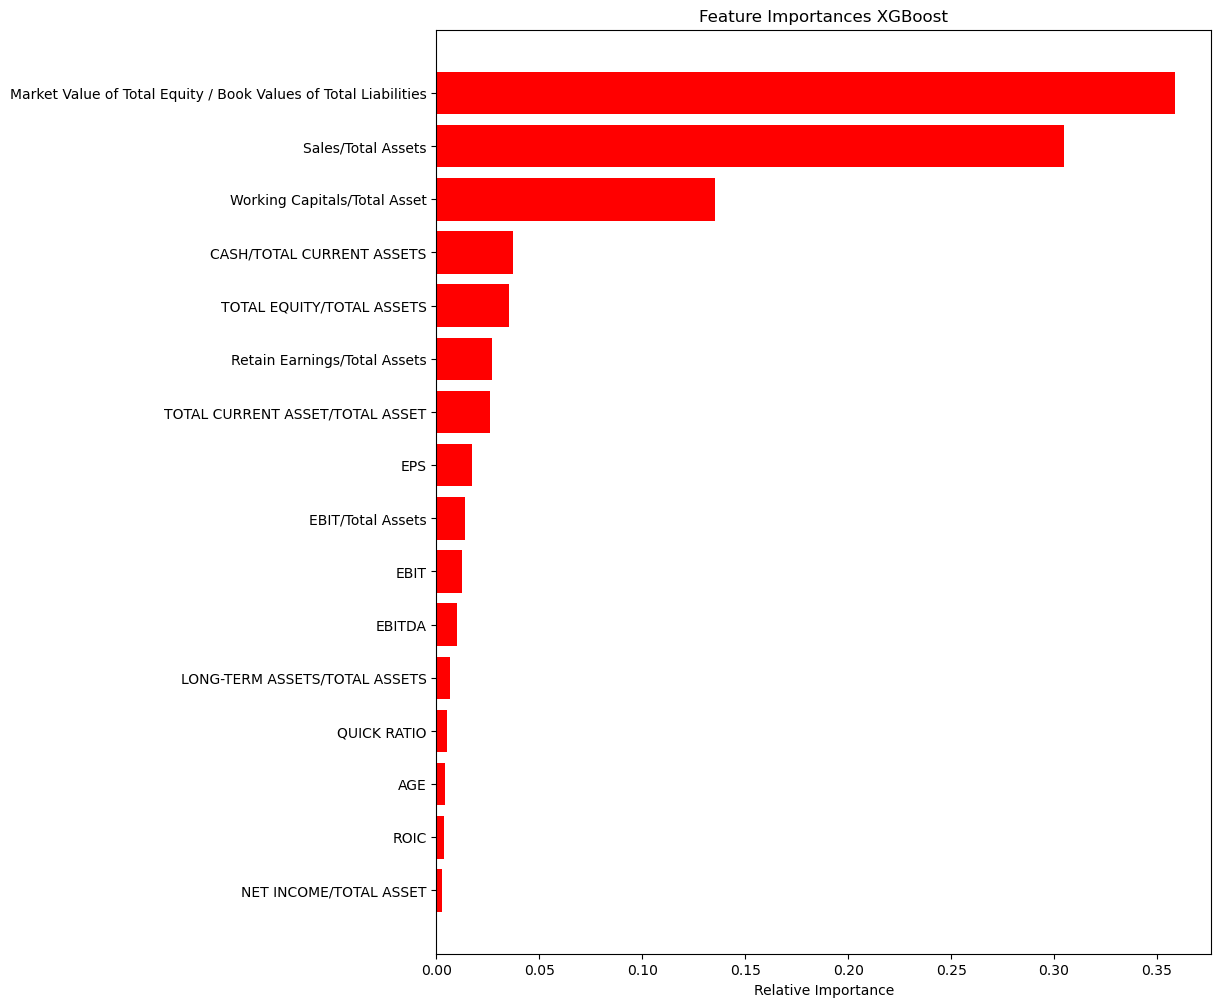

In [20]:
features = X.columns
importances = xgboost_model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances XGBoost')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## LightGBM Training


In [21]:
import lightgbm as lgb

# Convert data to LightGBM Dataset format
lgb_data = lgb.Dataset(X, label=y)

# Define parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Perform cross-validation to train the model
cv_results = lgb.cv(params, lgb_data, num_boost_round=100, nfold=5, metrics='binary_error', seed=42)
scores = cross_val_score(lgb.LGBMClassifier(), X, y, cv=5, scoring=metric)
all_scores.append(scores)

# Train the final model with the best number of boosting rounds
best_num_boost_round = len(cv_results['valid binary_error-mean'])
lbg_model = lgb.train(params, lgb_data, num_boost_round=best_num_boost_round)

y_pred_prob = lbg_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = (y_pred_prob >= 0.5).astype(int)  # Assuming threshold of 0.5

y_scores = model.predict_proba(X_test)[:, 1] 
report = classification_report(y_test, y_pred)
# Tính AUROC
auroc = roc_auc_score(y_test, y_scores)

# Tính AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
# all_scores.append(scores)
print(f"\n==========Model: LightGBT==========")
# print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
print(report)
print(f"AUROC: {auroc}")
print(f"AUC-PR: {auc_pr}")

# Print cross-validation results
# print("Cross-validation results:", cv_results)
# print("Mean binary error:", np.mean(cv_results['valid binary_error-mean']))
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 242, number of negative: 250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 492, number of used features: 16
[LightGBM] [Info] Number of positive: 242, number of negative: 250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 492, number of used features: 16
[LightGBM] [Info] Number of positive: 242, number of negative: 250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remo

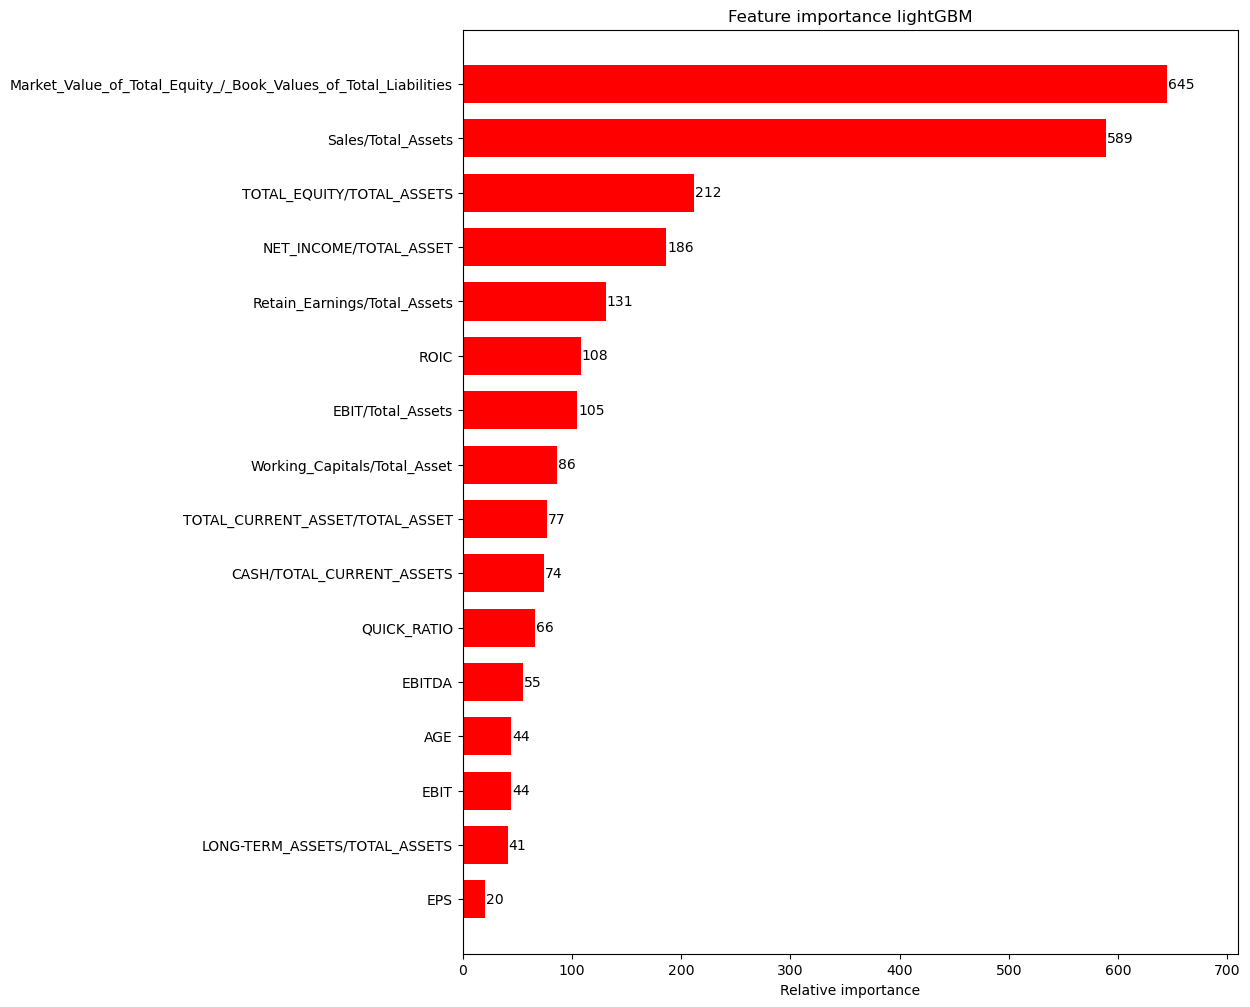

In [22]:
lgb.plot_importance(lbg_model, max_num_features=25, figsize=(10, 12),grid=False, height=0.7, color='red', title='Feature importance lightGBM', xlabel='Relative importance', ylabel='')

plt.show()  

## CatBoost Training

In [23]:
from catboost import CatBoostClassifier
# Initialize CatBoostClassifier classifier
catboost_model = CatBoostClassifier()

# Perform cross-validation
scores = cross_val_score(catboost_model, X, y, cv=5, scoring=metric)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
y_scores = catboost_model.predict_proba(X_test)[:, 1] 
report = classification_report(y_test, y_pred)
# Tính AUROC
auroc = roc_auc_score(y_test, y_scores)

# Tính AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
all_scores.append(scores)
print(f"==========Model: CatBoost==========")
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
print(report)
print(f"AUROC: {auroc}")
print(f"AUC-PR: {auc_pr}")

Learning rate set to 0.00761
0:	learn: 0.6833072	total: 48.5ms	remaining: 48.4s
1:	learn: 0.6743775	total: 49.8ms	remaining: 24.9s
2:	learn: 0.6653797	total: 51.6ms	remaining: 17.2s
3:	learn: 0.6552097	total: 53.2ms	remaining: 13.2s
4:	learn: 0.6453081	total: 56ms	remaining: 11.1s
5:	learn: 0.6349446	total: 57.6ms	remaining: 9.54s
6:	learn: 0.6246226	total: 59.6ms	remaining: 8.46s
7:	learn: 0.6140866	total: 61.9ms	remaining: 7.67s
8:	learn: 0.6045354	total: 64.1ms	remaining: 7.06s
9:	learn: 0.5962748	total: 66.4ms	remaining: 6.57s
10:	learn: 0.5878324	total: 68.1ms	remaining: 6.13s
11:	learn: 0.5800257	total: 70.7ms	remaining: 5.82s
12:	learn: 0.5725311	total: 73.3ms	remaining: 5.57s
13:	learn: 0.5655811	total: 75.3ms	remaining: 5.3s
14:	learn: 0.5580021	total: 76.8ms	remaining: 5.04s
15:	learn: 0.5490473	total: 78.9ms	remaining: 4.85s
16:	learn: 0.5408308	total: 81ms	remaining: 4.69s
17:	learn: 0.5336104	total: 82.7ms	remaining: 4.51s
18:	learn: 0.5246681	total: 84.8ms	remaining: 4.38

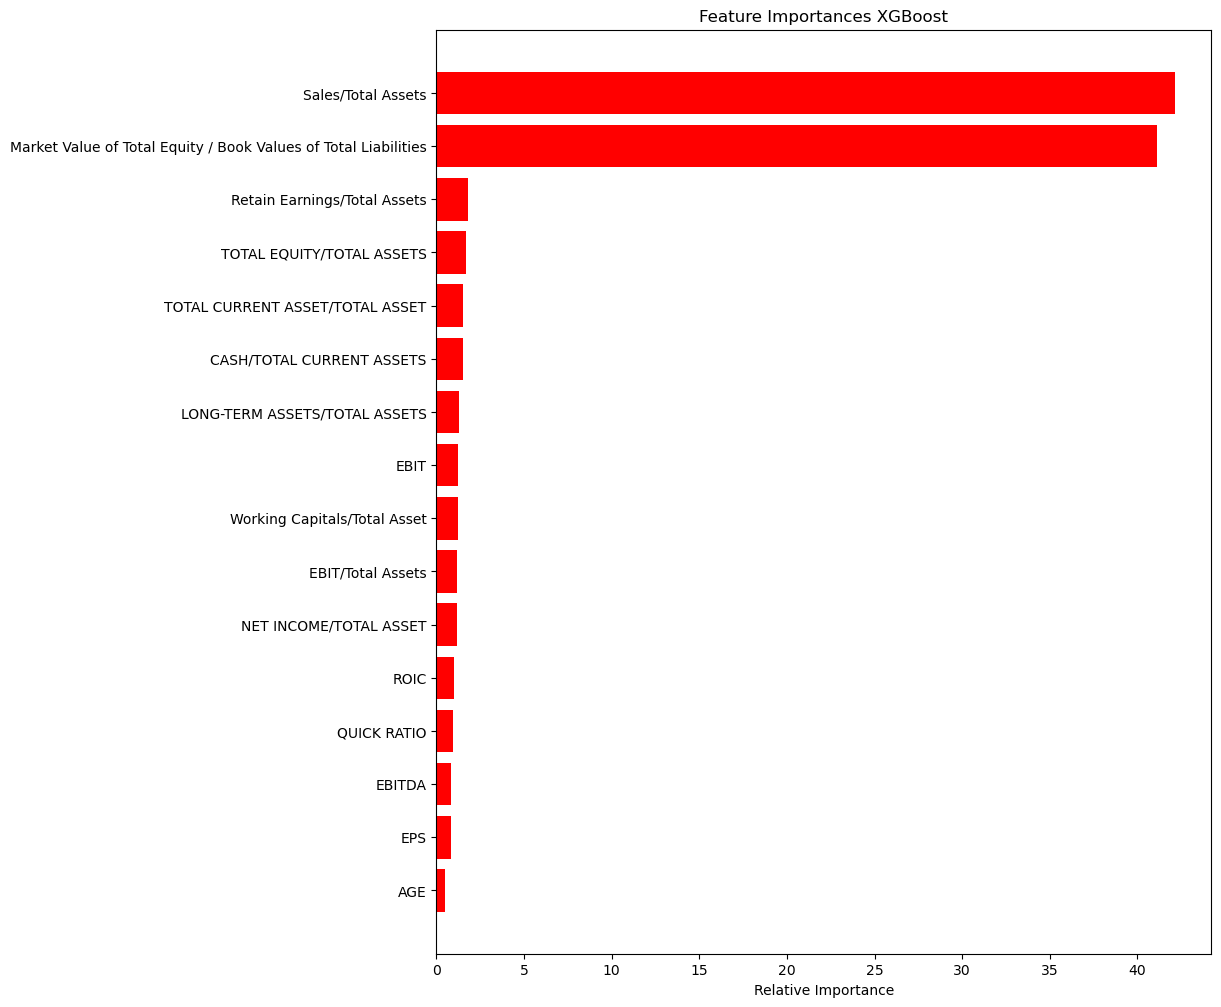

In [24]:
features = X.columns
importances = catboost_model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances XGBoost')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Text(0.5, 1.0, 'Scores Metrics')

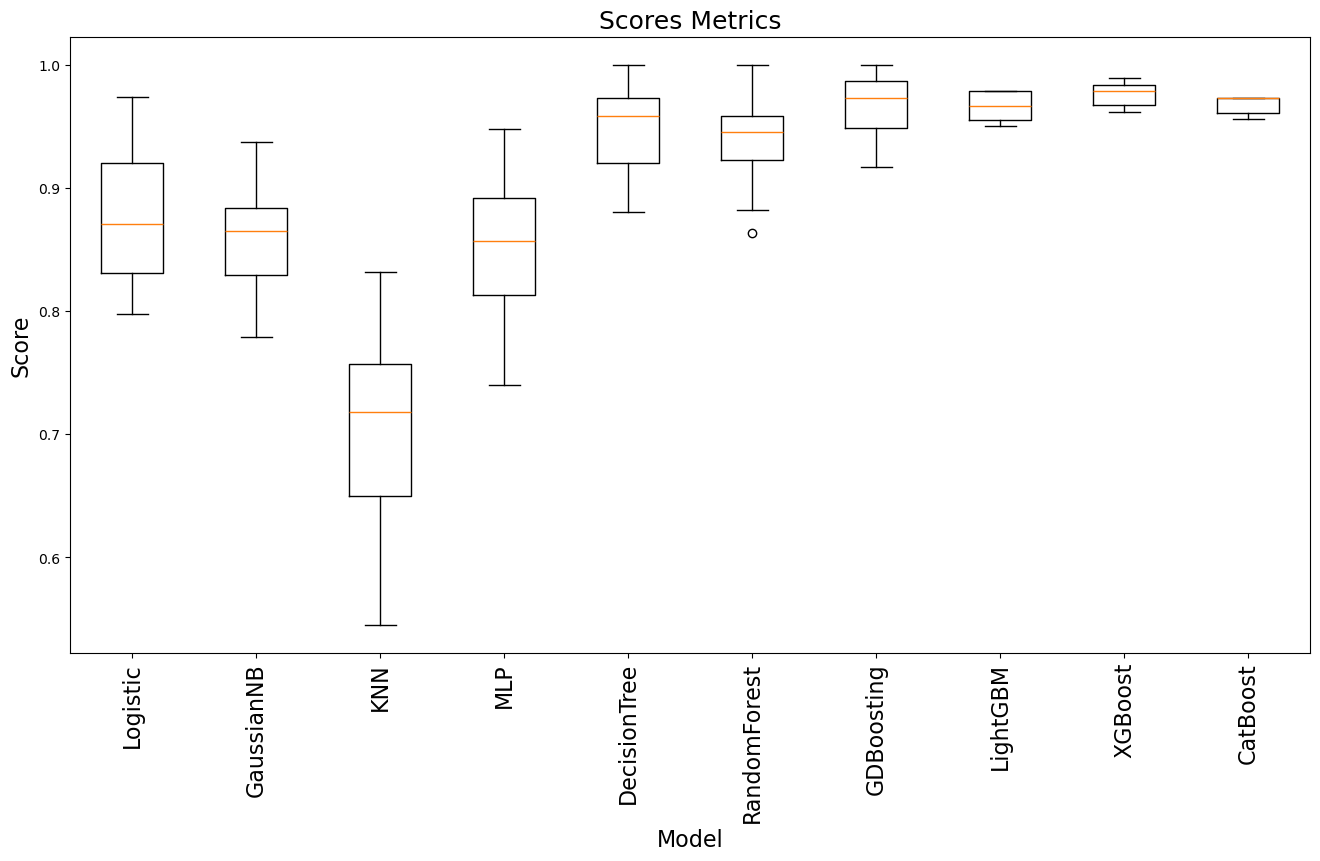

In [25]:
import matplotlib.pyplot as plt
model_names = ['Logistic', 'GaussianNB', 'KNN', 'MLP','DecisionTree', 'RandomForest', 'GDBoosting', 'LightGBM', 'XGBoost', 'CatBoost']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=90, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

In [26]:
# joblib.dump(catboost_model, 'best_model.pkl')